# sup7B

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/anndata/_core/anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/fengyu/miniconda3/envs/st/lib/python3.8/s

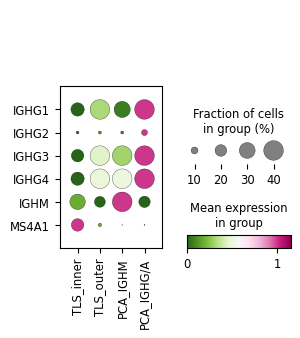

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- Load and merge meta info ---
adata = sc.read_h5ad('/data3/zhangyang/Method_Final_analysis/all_sample_data/all_sample_celltype.h5ad')
meta = pd.read_csv('/data1/fengyu/methods/fig5/LA_bin50_meta.csv', index_col=0)
adata.obs['loc'] = adata.obs['batch'].astype(str) + '_' + adata.obs['bin50_x'].map(str) + '_' + adata.obs['bin50_y'].map(str)
adata.obs = adata.obs.merge(meta[['loc', 'LA_anno']], on='loc', how='left')

# --- Normalize and log1p counts ---
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.obs_names = adata.obs_names.astype(str)

# --- Subset for LA annotation and celltype of interest ---
LA = adata[adata.obs['LA_anno'].notna()]
select_LA = ['TLS_inner', 'TLS_outer', 'PCA_IGHM', 'PCA_IGHG/A']
keep_ct = ['plasma_cell', 'b_cell']
data = adata[adata.obs['LA_anno'].isin(select_LA)]
data = data[data.obs['anno'].isin(keep_ct)]

# --- Plot: Dotplot for main immunoglobulin genes grouped by LA annotation ---
sc.pl.dotplot(
    data,
    ['IGHG1', 'IGHG2', 'IGHG3', 'IGHG4', 'IGHM', 'MS4A1'],
    groupby='LA_anno',
    cmap='PiYG_r',
    standard_scale='var',
    vmax=1.15,
    swap_axes=True,
    dot_max=0.4,
    categories_order=select_LA
)

# sup7C

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


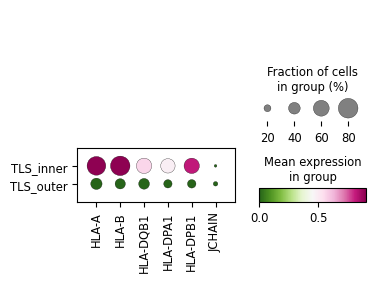

In [2]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# --- (optional) restore default matplotlib style ---
plt.rcParams.update(plt.rcParamsDefault)

# --- Load binned LA AnnData and plot ---
la_adata = sc.read_h5ad('/data1/fengyu/methods/zy/Review/for_github/fig4--ok/LA_bin50.h5ad')
sc.pl.dotplot(
    la_adata[la_adata.obs['LA_anno'].isin(['TLS_inner', 'TLS_outer'])],
    ['HLA-A', 'HLA-B', 'HLA-DQB1', 'HLA-DPA1', 'HLA-DPB1', 'JCHAIN'],
    groupby='LA_anno',
    swap_axes=False,
    use_raw=False,
    vmax=0.9,
    vmin=0,
    cmap='PiYG_r',
)

# sup7D

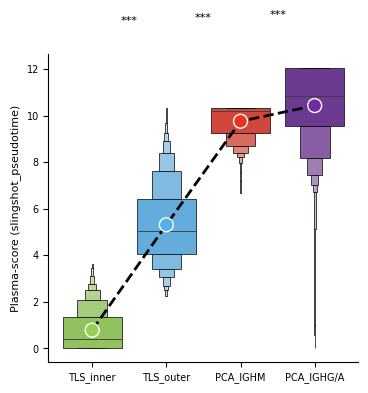

In [3]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
import numpy as np

plt.rcParams.update(plt.rcParamsDefault)

# --- Load AnnData and extract obs as DataFrame ---
LA_cell = sc.read_h5ad('/data1/fengyu/methods/zy/Review/for_github/fig4--ok/LA_cells.h5ad')
df = LA_cell.obs

order = ['TLS_inner', 'TLS_outer', 'PCA_IGHM', 'PCA_IGHG/A']
region_palette = ['#702C9F', '#E93323', '#93D150', '#4FB0F0']

plt.figure(figsize=(4, 4))
ax = sns.boxenplot(
    data=df,
    x='LA_anno',
    y='slingshot_pseudotime',
    hue='LA_anno',
    palette=region_palette,
    order=order,
    linewidth=0.5,
    alpha=1,
    showfliers=False,
    edgecolor='black'
)

# Add statistical comparison stars (pairwise t-test)
pairs = [
    ('TLS_inner', 'TLS_outer'),
    ('TLS_outer', 'PCA_IGHM'),
    ('PCA_IGHM', 'PCA_IGHG/A')
]
height = df['slingshot_pseudotime'].max() * 1.15
y_increment = 0.04

for i, (g1, g2) in enumerate(pairs):
    d1 = df.loc[df['LA_anno'] == g1, 'slingshot_pseudotime'].values
    d2 = df.loc[df['LA_anno'] == g2, 'slingshot_pseudotime'].values
    _, p = ttest_ind(d1, d2, equal_var=False)
    if p < 0.001:
        star = '***'
    elif p < 0.01:
        star = '**'
    elif p < 0.05:
        star = '*'
    else:
        star = 'ns'
    x1, x2 = order.index(g1), order.index(g2)
    ax.text((x1 + x2) * 0.5, height + y_increment, star,
            ha='center', va='bottom', color='black', fontsize=8)
    height += y_increment * 3

# Overlay mean pseudotime/trajectory
medians = df.groupby('LA_anno')['slingshot_pseudotime'].mean().reindex(order)
plt.scatter(
    x=medians.index, y=medians.values,
    color=['#93D150', '#4FB0F0', '#E93323', '#702C9F'],
    s=100, zorder=5, edgecolor='white'
)
plt.plot(
    medians.index, medians.values,
    color='black', linestyle='--', linewidth=2, zorder=4
)

ax.set_xlabel('')
ax.set_ylabel('Plasma-score (slingshot_pseudotime)', fontsize=8)
ax.tick_params(axis='both', labelsize=7)
plt.legend([], [], frameon=False)   # Remove extra legends
plt.grid(False)
sns.despine()
plt.show()

# sup7E

/home/fengyu/miniconda3/envs/st/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_868015/123244106.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cellborder['cellID'] = df_cellborder['cellID'].astype(str)
/tmp/ipykernel_868015/123244106.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PiYG_r')


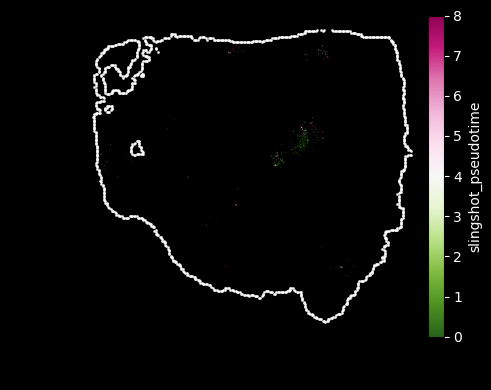

/tmp/ipykernel_868015/123244106.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cellborder['cellID'] = df_cellborder['cellID'].astype(str)
/tmp/ipykernel_868015/123244106.py:55: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('PiYG_r')


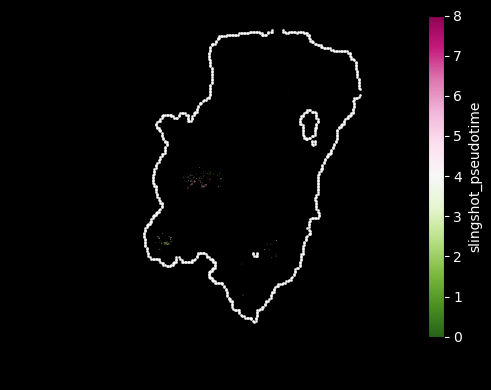

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
from matplotlib.path import Path
from matplotlib.patches import PathPatch
from matplotlib.collections import PatchCollection
from scipy.interpolate import splprep, splev
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import scanpy as sc

def plot_LA_border_colored_pseudotime(
    adata1_path,      # e.g. '/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2.h5ad'
    batch_id,         # e.g. 'D06047A2'
    la_cells_path,    # e.g. '/data1/fengyu/methods/zy/Review/for_github/fig4--ok/LA_cells.h5ad'
):
    # --- Load base AnnData with borders and tissue outline ---
    adata1 = sc.read_h5ad(adata1_path)
    LA_cell = sc.read_h5ad(la_cells_path)

    # Cells with IGHcdr3aa or IGK/Lcdr3aa   
    cells_mask = LA_cell.obs['IGHcdr3aa'].notna() | LA_cell.obs['IGK/Lcdr3aa'].notna()
    LA = LA_cell[cells_mask].copy()
    LA.obsm['X_umap'] = LA.obsm['spatial']
    df1 = LA[(LA.obs['batch'] == batch_id) & (LA.obs['bin50 structural annotation'] == 'LA-TLS')].obs.reset_index()
    tissue_outline = pd.DataFrame(adata1.uns['tissue_outline'], columns=['x', 'y'])

    # Fetch cell borders and merge with cell centroids by cellID
    array_2d = adata1.obsm['cell_border'].reshape(-1, adata1.obsm['cell_border'].shape[-1])
    df_border = pd.DataFrame(array_2d, columns=['x', 'y'])
    df_border['cellID'] = df_border.index // 32  # *Adjust if your border sampling changes!
    df_border['cellID'] = df_border['cellID'].astype(str)
    df_border = df_border[(df_border['x'] != 32767) & (df_border['y'] != 32767)]
    adata1.obs['cellID'] = adata1.obs['cellID'].astype(str)
    df_border = pd.merge(df_border, adata1.obs[['x', 'y', 'cellID']], on='cellID', how='left')
    df_border['x'] = df_border['x_x'] + df_border['x_y']
    df_border['y'] = df_border['y_x'] + df_border['y_y']
    df_cellborder = df_border[['cellID', 'x', 'y']]

    # Get all target cells and their boundaries
    cell_list1 = df1['cellID'].astype(str).tolist()
    df_cellborder['cellID'] = df_cellborder['cellID'].astype(str)
    cell_border1 = df_cellborder[df_cellborder['cellID'].isin(cell_list1)]
    cell_border_list1 = cell_border1.groupby('cellID').apply(
        lambda group: [[x, y] for x, y in zip(group['x'], group['y'])]
    ).tolist()
    filtered_cell_borders_list1 = [np.array(cell) for cell in cell_border_list1]
    time_list = df1['slingshot_pseudotime'].tolist()

    # --- Plot patches colored by pseudotime ---
    BG_COLOR = 'black'
    TXT_COLOR = 'white'
    cmap = cm.get_cmap('PiYG_r')
    norm = Normalize(vmin=0, vmax=8)

    def smooth_boundary(boundary, smoothness=0.5):
        x = boundary[:, 0]
        y = boundary[:, 1]
        x = np.append(x, x[0])
        y = np.append(y, y[0])
        tck, u = splprep([x, y], s=smoothness * len(x), per=True)
        u_new = np.linspace(u.min(), u.max(), 100)
        x_new, y_new = splev(u_new, tck, der=0)
        return np.column_stack((x_new, y_new))

    patches = []
    for i, cell_boundary in enumerate(filtered_cell_borders_list1):
        if len(cell_boundary) < 3:
            continue
        smooth = smooth_boundary(cell_boundary, 0.8)
        codes = [Path.LINETO] * len(smooth)
        codes[0] = Path.MOVETO
        codes[-1] = Path.CLOSEPOLY
        color_rgba = cmap(norm(time_list[i]))
        patches.append(PathPatch(Path(smooth, codes),
                                 edgecolor=None,
                                 facecolor=color_rgba,
                                 lw=0.01,
                                 antialiased=True))
    fig, ax = plt.subplots(figsize=(5, 4))
    fig.patch.set_facecolor(BG_COLOR)
    ax.set_facecolor(BG_COLOR)
    collection = PatchCollection(patches, match_original=True)
    ax.add_collection(collection)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.05, pad=0.02)
    cbar.set_label('slingshot_pseudotime', color=TXT_COLOR, fontsize=10)
    cbar.ax.yaxis.set_tick_params(color=TXT_COLOR, labelcolor=TXT_COLOR)
    sns.scatterplot(data=tissue_outline, x='x', y='y', color='white', s=3, edgecolor=None, ax=ax)
    plt.grid(False)
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

# --------- Single function calls ---------
# A2
plot_LA_border_colored_pseudotime(
    adata1_path='/data3/zhangyang/Method_Final_analysis/D06047A2/test_analysis_celltype/D06047A2.h5ad',
    batch_id='D06047A2',
    la_cells_path='/data1/fengyu/methods/zy/Review/for_github/fig4--ok/LA_cells.h5ad',
)
# E1
plot_LA_border_colored_pseudotime(
    adata1_path='/data3/zhangyang/Method_Final_analysis/D06047E1/test_analysis_celltype/D06047E1.h5ad',
    batch_id='D06047E1',
    la_cells_path='/data1/fengyu/methods/zy/Review/for_github/fig4--ok/LA_cells.h5ad',
)